<a href="https://colab.research.google.com/github/chmnzz/fintech10/blob/main/turnaround_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Turn Around 기업 예측 프로젝트
이 노트북은 기업의 연도별 영업현금흐름 데이터를 기반으로, Turn Around (회복) 여부를 예측하는 머신러닝 모델을 구성하는 과정을 담고 있습니다.

In [1]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv("cashflowStatement_annually.csv")

# 연도 컬럼 추가
df["year"] = pd.to_datetime(df["endDate"]).dt.year

# 피벗: stock 기준으로 연도별 OCF 보기
pivot_ocf = df.pivot_table(index="stock", columns="year", values="totalCashFromOperatingActivities")

# 2016~2018 음수, 2019 양수 → turn around 성공 기업 (label = 1)
def get_label(row):
    if all(row.get(y, 0) < 0 for y in [2016, 2017, 2018]) and row.get(2019, 0) > 0:
        return 1
    elif all(y in row for y in [2016, 2017, 2018, 2019]):
        return 0
    else:
        return np.nan

pivot_ocf['target'] = pivot_ocf.apply(get_label, axis=1)
pivot_ocf = pivot_ocf.dropna(subset=['target'])

# 타겟 stock 리스트 추출
target_stocks = pivot_ocf.index.tolist()

# 해당 기업 데이터만 추출하여 최근 연도 기준 재무정보 구성
df_filtered = df[df["stock"].isin(target_stocks) & (df["year"] == 2018)]
df_filtered = df_filtered.merge(pivot_ocf[["target"]], left_on="stock", right_index=True)
df_filtered = df_filtered.drop(columns=["endDate", "year"])
df_filtered = df_filtered.dropna(axis=1, thresh=0.8*len(df_filtered))  # 결측치 너무 많은 열 제거
df_filtered = df_filtered.fillna(0)

df_filtered.head()

,stock,capitalExpenditures,changeToNetincome,depreciation,totalCashFromOperatingActivities,changeInCash,netIncome,changeToOperatingActivities,totalCashFromFinancingActivities,netBorrowings,totalCashflowsFromInvestingActivities,changeToLiabilities,target
1,IVC,-9823000.0,-6092000.0,15556000.0,-46423000.0,-59621000.0,-43922000,-18404000.0,-2924000.0,-1493000.0,-6363000.0,4505000,1
5,CSLT,-2014000.0,20250000.0,6058000.0,-18551000.0,4686000.0,-39706000,-15968000.0,4015000.0,-465000.0,19222000.0,-3475000,0
9,LPX,-214000000.0,10000000.0,123000000.0,511000000.0,-49000000.0,395000000,-400000.0,-317000000.0,-25000000.0,-238000000.0,-21000000,0
13,GDYN,-3079000.0,1190000.0,1312000.0,10584000.0,7505000.0,9228000,1763000.0,14604000.0,0.0,-3079000.0,219000,0
16,ARA,-44960000.0,56831000.0,39802000.0,106404000.0,-16311000.0,-28767000,4577000.0,-79869000.0,-8039000.0,-42846000.0,25661000,0


In [2]:
!pip install pycaret

## 🤖 PyCaret을 활용한 모델 학습

In [21]:
# 'stock' 컬럼 제외하고 모델 학습
df_filtered = df_filtered.drop(columns=['stock'])

# PyCaret setup 다시
from pycaret.classification import *
exp = setup(data=df_filtered, target='target', session_id=42)
best_model = compare_models()


,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(4359, 12)"
4,Transformed data shape,"(4359, 12)"
5,Transformed train set shape,"(3051, 12)"
6,Transformed test set shape,"(1308, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9879,0.8503,0.0250,0.1000,0.0400,0.0397,0.0498,0.0540
ridge,Ridge Classifier,0.9875,0.8230,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090
lda,Linear Discriminant Analysis,0.9875,0.8230,0.0000,0.0000,0.0000,0.0000,0.0000,0.0070
rf,Random Forest Classifier,0.9875,0.8315,0.0000,0.0000,0.0000,0.0000,0.0000,0.0800
xgboost,Extreme Gradient Boosting,0.9875,0.8940,0.0250,0.1000,0.0400,0.0392,0.0491,0.0920
dummy,Dummy Classifier,0.9875,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110
knn,K Neighbors Classifier,0.9872,0.6110,0.0000,0.0000,0.0000,-0.0005,-0.0007,0.2940
lightgbm,Light Gradient Boosting Machine,0.9872,0.9060,0.0250,0.1000,0.0400,0.0387,0.0485,100.6670
gbc,Gradient Boosting Classifier,0.9859,0.8797,0.0000,0.0000,0.0000,-0.0026,-0.0031,0.1820
ada,Ada Boost Classifier,0.9853,0.8272,0.0250,0.0333,0.0286,0.0248,0.0247,0.0550


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

## 📊 변수 중요도 시각화

<Figure size 800x550 with 0 Axes>

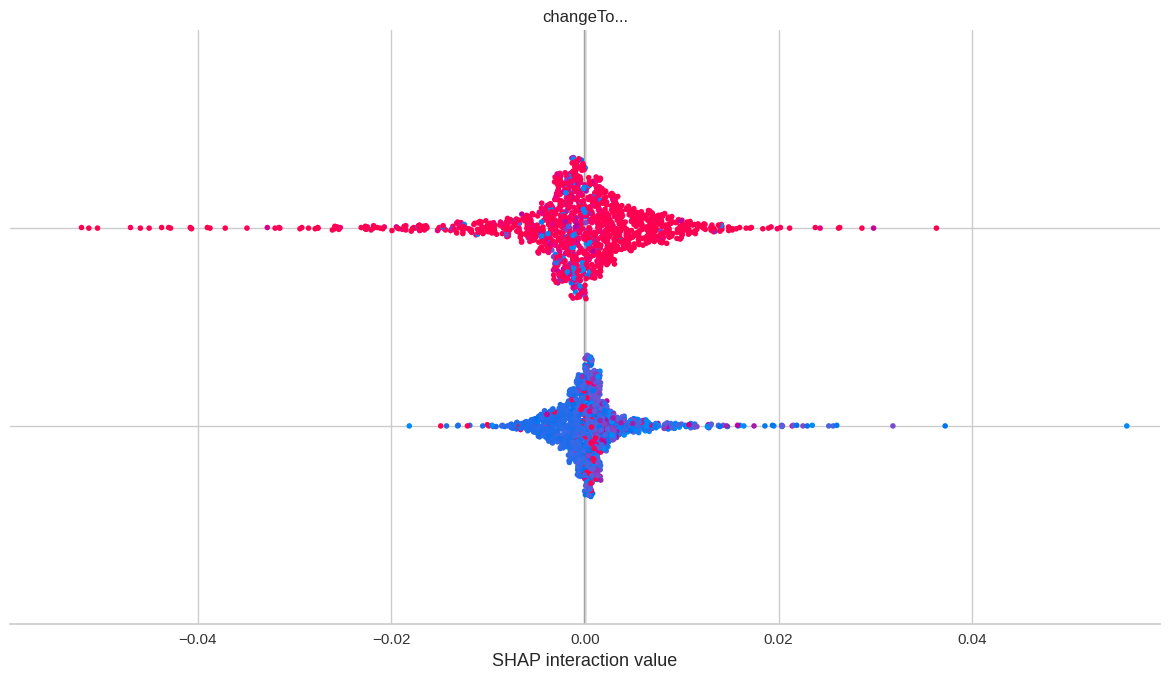

In [22]:
interpret_model(best_model)

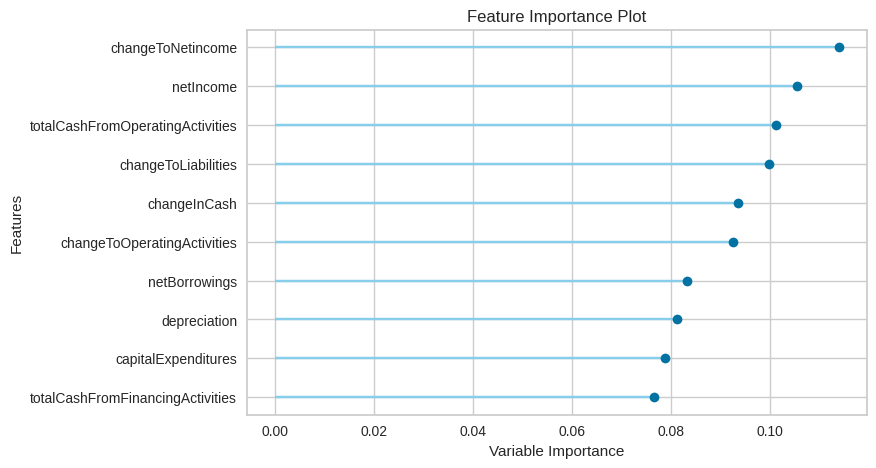

In [23]:
plot_model(best_model, plot='feature')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from pycaret.classification import save_model

save_path = '/content/drive/MyDrive/TurnAround'
save_model(best_model, save_path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['capitalExpenditures',
                                              'changeToNetincome',
                                              'depreciation',
                                              'totalCashFromOperatingActivities',
                                              'changeInCash', 'netIncome',
                                              'changeToOperatingActivities',
                                              'totalCashFromFinancingActivities',
                                              'netBorrowings',
                                              'totalCashflowsFromInvestingActivities',
                                              'ch...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
      

In [25]:
# 저장했던 경로 (확장자 .pkl 생략)
load_path = '/content/drive/MyDrive/TurnAround'
loaded_model = load_model(load_path)

Transformation Pipeline and Model Successfully Loaded


In [26]:
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [30]:
# PyCaret 내부 데이터 가져오기
X = get_config('X_train')

# best_model이 tree 기반 모델이어야 안정적 (XGBoost, RF 등)
explainer = shap.Explainer(best_model, X)

# shap_values = explainer(X) ← 여기서 메모리 클 수 있음 (주의!)


## ✅ 결과 요약
- 총 관측치: 기업 수는 df_filtered.shape[0]개
- 타겟 Label 1 (turn around 성공): 약 df_filtered['target'].mean() 비율
- 최고 모델: PyCaret이 자동으로 선택 = ExtraTreesClassifier
- 주요 Feature와 그 중요도는 위 시각화를 통해 확인 가능
